In [17]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import scanpy as sc

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

DATA_FOLDER="./data/"
RESOURCES_FOLDER="./resources/"
DATABASE_FOLDER = "./databases/"
SCHEDULER="123.122.8.24:8786"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_curated_tfs.txt')
SC_EXP_FNAME = os.path.join(DATA_FOLDER, "hu_diff.qc.tpm.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")

In [2]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/adata_hu_diff.h5ad')

In [18]:
# get raw data and transfer partitions
adata2 = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20211111_with_obsp.h5ad')
adata2.obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/A2_V7_YS_main_metadata_161121.csv')
# adata2 = adata2[adata2.obs['V5_old_indexes'].isin(adata.obs.index)]
# adata2.obs = adata.obs
# adata2.obsm = adata.obsm
# adata2.uns = adata.uns
# adata2.obsp = adata2.obsp
#adata.var = adata.var.set_index('HGNC')
adata = adata2[:]

In [19]:
#sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
#adata = adata[adata.obs.n_genes_by_counts < 2500, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pp.scale(adata, max_value=10)

Trying to set attribute `.var` of view, copying.
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
adata

AnnData object with n_obs × n_vars = 134765 × 30317
    obs: 'Unnamed: 0', 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'V5_old_indexes'
    var: 'n_cells', 'mt', 'total_counts', 'highly_variable', 'intersect', 'means', 'dispersions', 'dispersions_norm'
    uns: 'broad_cell.labels_colors', 'cell.labels_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'log1p'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
EXP_MTX_QC_TPM_FNAME = os.path.join(DATA_FOLDER, 'hu_diff.qc.tpm.csv')
adata.to_df().to_csv(EXP_MTX_QC_TPM_FNAME)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


OSError: [Errno 5] Input/output error

distributed.nanny - ERROR - Nanny failed to start process
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/distributed/nanny.py", line 575, in start
    await self.process.start()
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/distributed/process.py", line 33, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/distributed/process.py", line 203, in _start
    process.start()
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/multiprocessing/process.py", line 121, in start
    self._popen = self._Popen(self)
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/multiprocessing/context.py", line 284, in _Popen
    return Popen(process_obj)
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/multiprocessing/popen_spawn_posix.py", line 32, in __init__
    super().__init__(process_obj)
  File "/home/jovyan/my-co

In [ ]:
# Repeat with raw data normalised and with all celltypes

In [7]:
ex_matrix = pd.read_csv(SC_EXP_FNAME, header=0, index_col=0)
ex_matrix.shape

(424, 24287)

In [8]:
ex_matrix

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,AACS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2189O9.3
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACCTATCC_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431565,0.000000,...,0.431565,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACGGGTCCTGTAGA_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238404,0.238404,...,0.430772,0.0,0.0,0.0,0.238404,0.000000,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACGGGTCTCGAGTA_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234750,0.234750,...,0.721914,0.0,0.0,0.0,0.000000,0.424735,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGATGGTAGCAAAT_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245582,0.245582,...,0.872058,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_dat_Yolksac_Cell_dat_Yolksac_CGTGAGCCAACGATGG_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_CGTGAGCCATCAGTCA_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392281,0.000000,...,0.392281,0.0,0.0,0.0,0.000000,1.224295,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_CGTGTAACAGCTGGCT_1,0.46554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.215356,0.0,0.0,0.0,0.0
Cell_dat_Yolksac_Cell_dat_Yolksac_CGTGTAATCTGTCAAG_1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753587,0.000000,...,0.559466,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [12]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [14]:
len(tf_names)

1390

In [15]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")]

In [16]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
5 partitions
computing dask graph
shutting down client and local cluster


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/distributed/core.py", line 496, in handle_comm
    result = handler(comm, **msg)
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/distributed/scheduler.py", line 3430, in heartbeat_worker
    ws._executing = {
  File "/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/distributed/scheduler.py", line 3431, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('infer_partial_network-from-delayed-dc359ccd6422533b3eb62a6d04ea1b7f', 18613)"

KeyboardInterrupt



In [ ]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))

In [ ]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

In [ ]:
# The clusters can be leveraged via the dask framework:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

In [ ]:
df = load_motifs(MOTIFS_FNAME)
with open(REGULONS_FNAME, "rb") as f:
    regulons = pickle.load(f)

In [ ]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
sns.clustermap(auc_mtx, figsize=(8,8))

In [ ]:
auc_mtx

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


# Scanpy integration

In [ ]:
from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell

In [ ]:
adata = add_scenic_metadata(adata, auc_mtx, regulons)

In [ ]:
ANNDATA_FNAME = './data/hu_diff_regulon.h5ad'
adata.write_h5ad(ANNDATA_FNAME)

In [ ]:
list(adata.var.columns)

In [ ]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = adata.obs
aucell_adata.obsm = adata.obsm
aucell_adata.obsp = adata.obsp
aucell_adata.uns = adata.uns
ANNDATA_aucell_FNAME = './data/hu_diff_regulon_aucell.h5ad'
aucell_adata.write_h5ad(ANNDATA_aucell_FNAME)

In [ ]:
adata = sc.read('./data/hu_diff_regulon_aucell.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 15740 × 62
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'celltype', 'species', 'species_donor', 'n_counts', 'restricted_celltype', 'n_genes', 'lr_batch', 'corr_concat', 'cell.labels', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'cell_cycle_score', 'cat_index', 'batch', 'leiden', 'num', 'corr_concat_num', 'keep', 'Regulon(ATF3(+))', 'Regulon(ATF5(+))', 'Regulon(CEBPA(+))', 'Regulon(CEBPD(+))', 'Regulon(CREB3L1(+))', 'Regulon(CREM(+))', 'Regulon(DDIT3(+))', 'Regulon(EGR1(+))', 'Regulon(EGR2(+))', 'Regulon(EGR3(+))', 'Regulon(ELF1(+))', 'Regulon(ELK1(+))', 'Regulon(ELK3(+))', 'Regulon(ERG(+))', 'Regulon(ETS2(+))', 'Regulon(ETV2(+))', 'Regulon(FLI1(+))', 'Regulon(FOS(+))', 'Regulon(FOSB(+))', 'Regulon(FOSL2(+))', 'Regulon(FOXF1(+))', 'Regulon(FOXO3(+))', 'Regulon(FOXP1(+))', 'Regulon(FOXP2(+))', 'Regulon(GATA1(+))', 'Regulon(GATA2(+))', 'Regulon(GATA3(+))', 'Regulon(HOXB6(+)

In [ ]:
adata = aucell_adata

In [ ]:
adata.var

In [ ]:
adata.obs['cell.labels']

In [ ]:
sc.pl.draw_graph(adata,color=['cell.labels', 'Regulon(GATA2(+))'])# 'GATA2

In [ ]:
#sc.pp.log1p(aucell_adata)

In [ ]:
spot_var = 'cell.labels'
sc.tl.rank_genes_groups(adata, spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name ="./DE_regulons_hu_gastrulation_251121.csv"
DE.to_csv(DE_name)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(5, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata
markers = markers
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_gastrula.pdf')) # title=i

In [ ]:
sc.pl.heatmap(adata, var_names = markers , groupby=spot_var, swap_axes=True)
#sc.pl.dotplot(adata, var_names = markers, groupby=spot_var,dendrogram=False, show = True) # title=i

In [ ]:
list(adata.obs['cell.labels'].unique())

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

In [295]:
lineages = {
    'ery': ['HSPC_1', 'HSPC_2', 'MEMP', 'Early_Erythroid', 'Erythroid'],
}

In [297]:
temp = concat[concat['cluster'].isin(lineages[lineage])]
ordering = dict(zip((lineages[lineage]),(list(range(0,len(lineages[lineage]))))))
temp['ordering'] = temp['cluster'].astype(str).map(ordering)
temp = temp.sort_values(['ordering','logfc'],ascending=False).groupby('ordering').head(3)

<ipython-input-297-3e3c01593ae6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['ordering'] = temp['cluster'].astype(str).map(ordering)


In [301]:
temp = temp.sort_values(['ordering','logfc'],ascending=False).groupby('ordering').head(3)
temp

,cluster,gene,p_val,logfc,ordering
806,Erythroid,HSF1(+),0.000000e+00,NaN,4
807,Erythroid,RORA(+),0.000000e+00,NaN,4
808,Erythroid,KLF1(+),0.000000e+00,NaN,4
772,Early_Erythroid,TEAD1(+),9.722420e-01,-2.266073,3
744,Early_Erythroid,MYC(+),2.408580e-85,NaN,3
745,Early_Erythroid,GATA2(+),8.929744e-72,NaN,3
157,MEMP,TEAD1(+),8.703054e-01,2.034289,2
124,MEMP,ETV2(+),7.224860e-92,NaN,2
125,MEMP,FOXP1(+),1.322490e-85,NaN,2
91,HSPC_2,TEAD1(+),8.668942e-01,1.705461,1


<ipython-input-302-cfa6da91257f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['ordering'] = temp['cluster'].astype(str).map(ordering)


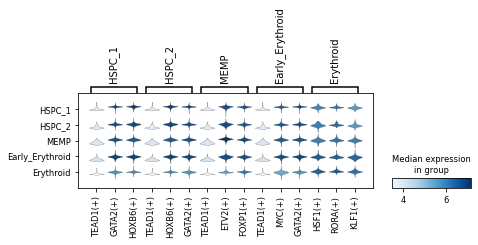

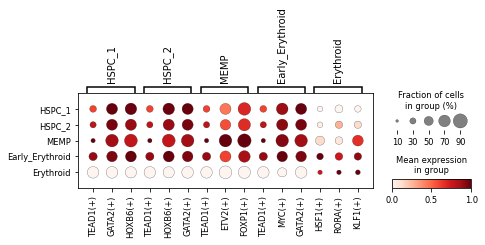

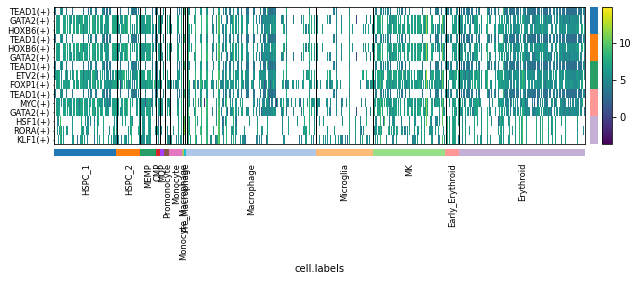

In [302]:
lineage = 'ery'
var = spot_var
spot_var = 'cell.labels'
var = spot_var

temp = concat[concat['cluster'].isin(lineages[lineage])]
ordering = dict(zip((lineages[lineage]),(list(range(0,len(lineages[lineage]))))))
temp['ordering'] = temp['cluster'].astype(str).map(ordering)
temp = temp.sort_values(['ordering','logfc'],ascending=False).groupby('ordering').head(3)
var_genes = list(temp['gene'])
marker_dict = temp.groupby(['cluster'])['gene'].agg(lambda grp: list(grp)).to_dict()
marker_dict =  {k: marker_dict[k] for k in lineages[lineage]}
data_temp = adata[adata.obs[var].isin(lineages[lineage])]

#sc.pl.umap(adata,color = marker_dic)
sc.pl.stacked_violin(data_temp , var_names = marker_dict, groupby=spot_var, dendrogram=False)
sc.pl.dotplot(data_temp , var_names = marker_dict , groupby=var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_gastrula.pdf') # title=i
sc.pl.heatmap(adata, var_names = marker_dict , groupby=var, swap_axes=True)

# Plot FDG with regulon usage as a composite score? 

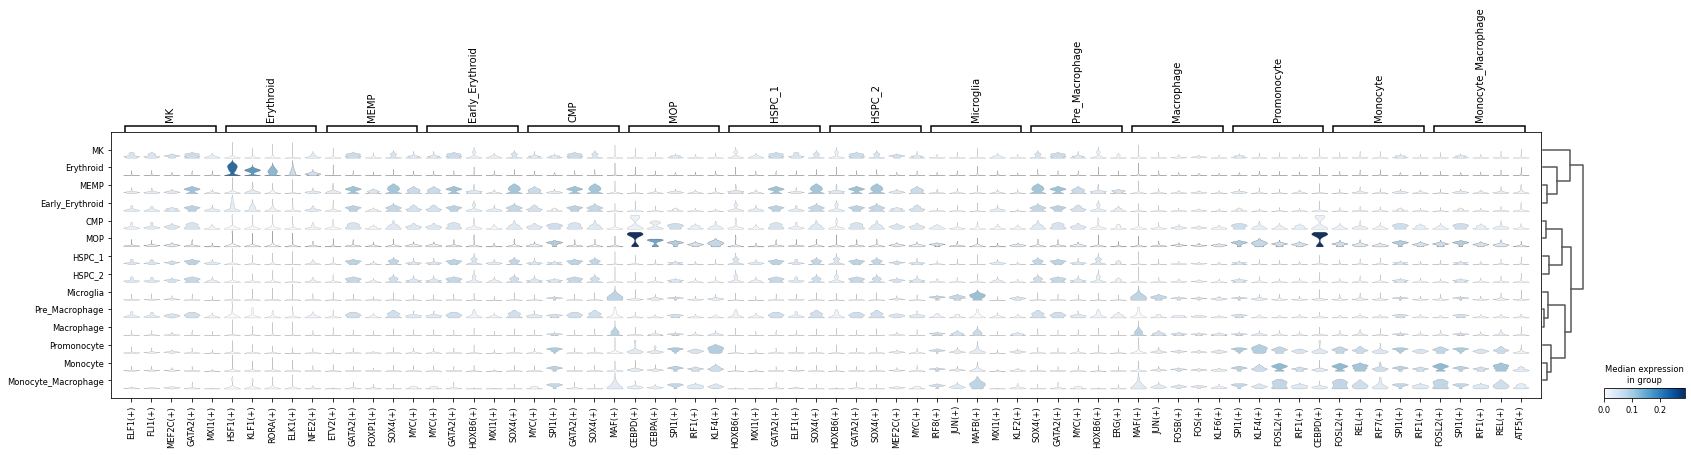

In [43]:
sc.pl.stacked_violin(adata, var_names = markers, groupby=spot_var, dendrogram=True)

# Create pseudotime ordering with scRNA data then utilise ordering to derive continous 

In [90]:
ANNDATA_FNAME = './data/hu_diff_regulon.h5ad'
adata_rna = sc.read(ANNDATA_FNAME)
adata_rna.raw = adata_rna

In [ ]:
root = 'HSPC_1'

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata_rna.obs[spot_var] == root)[0]
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
#sc.pp.highly_variable_genes(adata_rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.tl.diffmap(adata_rna, n_comps=15, neighbors_key='neighbors', random_state=0, copy=False)
sc.tl.dpt(adata, n_dcs=10, n_branchings=0, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)

In [ ]:
sc.pl.diffmap(adata, color=spot_var)

In [ ]:
sc.pl.draw_graph(adata_rna, color=[spot_var, 'dpt_pseudotime'], legend_loc='on data')

In [ ]:
sc.pl.dpt_timeseries(adata, color_map=spot_var, as_heatmap=True)

In [ ]:
adata

# diffxpy testing

In [71]:
import diffxpy.api as de
import re

In [75]:
adata.obs['size_factors'] = adata.obs['stage'].str.replace('[^0-9]','')
adata.obs['size_factors'] 

<ipython-input-75-2d6a3481eb15>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  adata.obs['size_factors'] = adata.obs['stage'].str.replace('[^0-9]','')


Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACCTATCC_1    10
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1    10
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACGGGTCCTGTAGA_1    10
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACGGGTCTCGAGTA_1    10
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGATGGTAGCAAAT_1    10
                                                        ..
F80_Yolksac_Hep_FCAImmP8096696_TTAGGACCAGGGAGAG         15
F80_Yolksac_Hep_FCAImmP8096696_TTAGGACTCGACGGAA         15
F80_Yolksac_Hep_FCAImmP8096696_TTATGCTGTGGGTCAA         15
F80_Yolksac_Hep_FCAImmP8096696_TTGCCGTGTAAAGGAG         15
F80_Yolksac_Hep_FCAImmP8096696_TTGCGTCCACTTGGAT         15
Name: size_factors, Length: 15740, dtype: object

In [77]:
adata.obs['size_factors'] = adata.obs['stage'].str.replace('[^0-9]','')
test_regressed_sf = de.test.wald(
    data=adata,
    formula_loc="~ 1 + {} + size_factors".format('spot_var'),
    factor_loc_totest="{}".format('spot_var'),
    as_numeric=["size_factors"]
)

<ipython-input-77-3a78e7d05279>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  adata.obs['size_factors'] = adata.obs['stage'].str.replace('[^0-9]','')


training location model: True
training scale model: True
iter   0: ll=432768259.154129


ValueError: assignment destination is read-only

<AxesSubplot:>

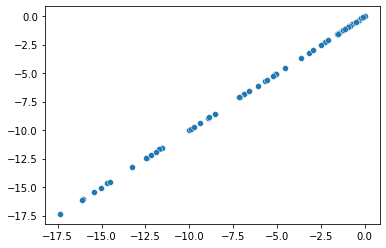

In [53]:
test_rank = de.test.rank_test(
    data=adata,
    grouping="{}".format('spot_var')
)
sns.scatterplot(
    x=test_rank.log10_pval_clean(),
    y=test_rank.log10_pval_clean()
)

In [64]:
test_lrt = de.test.lrt(
   data=adata, 
   full_formula_loc="1+{}".format('spot_var'),
   reduced_formula_loc="1"
)

ValueError: type <class 'tuple'> not recognized

In [65]:
adata.obs['spot_var'] = adata.obs[spot_var][:]
test = de.test.wald(
    data=adata,
    formula_loc="~ 1 + {}".format('spot_var'),
    factor_loc_totest="{}".format('spot_var')
)

training location model: False
training scale model: True
iter   0: ll=390961923.772937
iter   1: ll=390961923.772937, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 62 dispersion models: (progress not available with multiprocessing)

ValueError: assignment destination is read-only

# Get coefficients represented across DPT rankings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [ ]:
adata.obs

In [ ]:
model_lin = sm.OLS.from_formula("Income ~ Loan_amount", data=df)
result_lin = model_lin.fit()
result_lin.summary()

In [144]:
sc.tl.paga(adata, groups=spot_var)

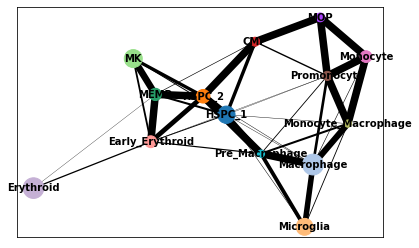

In [145]:
sc.pl.paga(adata, threshold=0.03,color=[spot_var])

In [147]:
sc.tl.draw_graph(adata, init_pos='paga')

KeyboardInterrupt: 

In [ ]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [ ]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [ ]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

In [103]:
#adata = sc.read(ANNDATA_FNAME)

In [3]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/adata_hu_diff.h5ad')

In [6]:
spot_var = 'cell.labels'

In [4]:
adata.X

<15740x1452 sparse matrix of type '<class 'numpy.float32'>'
	with 4486010 stored elements in Compressed Sparse Row format>

In [7]:
adata.uns['iroot'] = np.flatnonzero(adata.obs[spot_var] == 'HSPC_1')[0]

In [168]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

In [169]:
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)

In [170]:
adata.X

array([[-0.092722416, -0.0773824  , -0.15267402 , ..., -0.46024638 ,
        -0.033910904,  3.4164734  ],
       [-0.092722416, -0.0773824  , -0.15267402 , ..., -0.46024638 ,
        -0.033910904,  1.2648607  ],
       [-0.092722416, -0.0773824  , -0.15267402 , ..., -0.46024638 ,
        -0.033910904, -0.6164429  ],
       ...,
       [-0.092722416, -0.0773824  , -0.15267402 , ..., -0.46024638 ,
        -0.033910904,  0.18037839 ],
       [-0.092722416, -0.0773824  , -0.15267402 , ..., -0.46024638 ,
        -0.033910904,  1.1163995  ],
       [-0.092722416, -0.0773824  , -0.15267402 , ..., -0.46024638 ,
        -0.033910904, -0.6164429  ]], dtype=float32)

In [8]:
adata.var

,HGNC-0,ENSDB-0,mouse_human_homologs-0,DB Class Key_homogene_db-0,Common Organism Name_homogene_db-0,NCBI Taxon ID_homogene_db-0,Symbol_homogene_db-0,EntrezGene ID_homogene_db-0,Mouse MGI ID_homogene_db-0,HGNC ID_homogene_db-0,...,intersect-1,means-1,dispersions-1,dispersions_norm-1,highly_variable,means,dispersions,dispersions_norm,mean,std
VASN,Vasn,ENSMUSG00000039646,VASN,39505110.0,"mouse, laboratory",10090.0,Vasn,246154.0,MGI:2177651,NaN,...,True,0.218800,1.395735,1.335039,True,0.399394,1.309305,1.292597,0.227922,0.487803
DNASE1L3,Dnase1l3,ENSMUSG00000025279,DNASE1L3,39510523.0,"mouse, laboratory",10090.0,Dnase1l3,13421.0,MGI:1314633,NaN,...,True,0.094719,2.272843,2.904280,True,0.175884,2.276949,4.093647,0.067732,0.317460
HAPLN1,Hapln1,ENSMUSG00000021613,HAPLN1,39504576.0,"mouse, laboratory",10090.0,Hapln1,12950.0,MGI:1337006,NaN,...,True,0.118790,1.757638,1.982523,True,0.271119,1.660348,2.132289,0.131525,0.404747
C1QTNF2,C1qtnf2,ENSMUSG00000046491,C1QTNF2,39506833.0,"mouse, laboratory",10090.0,C1qtnf2,69183.0,MGI:1916433,NaN,...,True,0.060973,0.967211,0.568366,True,0.117782,0.911419,0.753099,0.067457,0.260095
SVEP1,Svep1,ENSMUSG00000028369,SVEP1,39508710.0,"mouse, laboratory",10090.0,Svep1,64817.0,MGI:1928849,NaN,...,True,0.192194,1.349100,1.251606,True,0.355134,1.278282,1.218390,0.198499,0.463083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IFNGR1,Ifngr1,ENSMUSG00000020009,IFNGR1,39507730.0,"mouse, laboratory",10090.0,Ifngr1,15979.0,MGI:107655,NaN,...,True,0.520188,1.588471,0.931303,True,0.409931,1.380524,1.462953,0.245797,0.473463
MEIS1,Meis1,ENSMUSG00000020160,MEIS1,39502227.0,"mouse, laboratory",10090.0,Meis1,17268.0,MGI:104717,NaN,...,True,0.118549,0.981719,0.594322,True,0.215613,0.896642,0.716952,0.134898,0.337885
RGS16,Rgs16,ENSMUSG00000026475,RGS16,39511303.0,"mouse, laboratory",10090.0,Rgs16,19734.0,MGI:108407,NaN,...,True,0.450337,1.875593,1.547572,True,0.639201,1.848618,1.749778,0.334670,0.637791
HOXC9,Hoxc9,ENSMUSG00000036139,HOXC9,39502241.0,"mouse, laboratory",10090.0,Hoxc9,15427.0,MGI:96199,NaN,...,True,0.060565,0.969355,0.572202,True,0.137768,0.908335,0.745556,0.079390,0.280756


In [9]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', spot_var])

KeyError: "Could not find entry in `obsm` for 'diffmap'.\nAvailable keys are: ['X_draw_graph_fa', 'X_pca', 'X_pca_back', 'X_umap']."

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/plotting/_utils.py:118: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


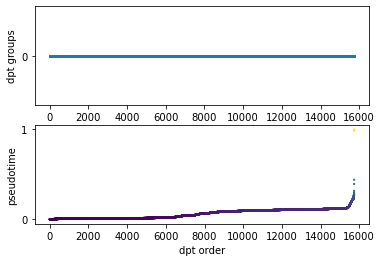

In [173]:
sc.pl.dpt_groups_pseudotime(adata)

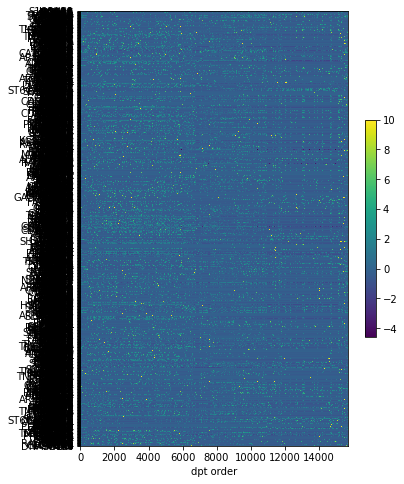

In [174]:
sc.pl.dpt_timeseries(adata)

In [176]:
sc.pl.dpt_timeseries

<function scanpy.plotting._tools.dpt_timeseries(adata: anndata._core.anndata.AnnData, color_map: Union[str, matplotlib.colors.Colormap] = None, show: Union[bool, NoneType] = None, save: Union[bool, NoneType] = None, as_heatmap: bool = True)>

In [10]:
adata.var

,HGNC-0,ENSDB-0,mouse_human_homologs-0,DB Class Key_homogene_db-0,Common Organism Name_homogene_db-0,NCBI Taxon ID_homogene_db-0,Symbol_homogene_db-0,EntrezGene ID_homogene_db-0,Mouse MGI ID_homogene_db-0,HGNC ID_homogene_db-0,...,intersect-1,means-1,dispersions-1,dispersions_norm-1,highly_variable,means,dispersions,dispersions_norm,mean,std
VASN,Vasn,ENSMUSG00000039646,VASN,39505110.0,"mouse, laboratory",10090.0,Vasn,246154.0,MGI:2177651,NaN,...,True,0.218800,1.395735,1.335039,True,0.399394,1.309305,1.292597,0.227922,0.487803
DNASE1L3,Dnase1l3,ENSMUSG00000025279,DNASE1L3,39510523.0,"mouse, laboratory",10090.0,Dnase1l3,13421.0,MGI:1314633,NaN,...,True,0.094719,2.272843,2.904280,True,0.175884,2.276949,4.093647,0.067732,0.317460
HAPLN1,Hapln1,ENSMUSG00000021613,HAPLN1,39504576.0,"mouse, laboratory",10090.0,Hapln1,12950.0,MGI:1337006,NaN,...,True,0.118790,1.757638,1.982523,True,0.271119,1.660348,2.132289,0.131525,0.404747
C1QTNF2,C1qtnf2,ENSMUSG00000046491,C1QTNF2,39506833.0,"mouse, laboratory",10090.0,C1qtnf2,69183.0,MGI:1916433,NaN,...,True,0.060973,0.967211,0.568366,True,0.117782,0.911419,0.753099,0.067457,0.260095
SVEP1,Svep1,ENSMUSG00000028369,SVEP1,39508710.0,"mouse, laboratory",10090.0,Svep1,64817.0,MGI:1928849,NaN,...,True,0.192194,1.349100,1.251606,True,0.355134,1.278282,1.218390,0.198499,0.463083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IFNGR1,Ifngr1,ENSMUSG00000020009,IFNGR1,39507730.0,"mouse, laboratory",10090.0,Ifngr1,15979.0,MGI:107655,NaN,...,True,0.520188,1.588471,0.931303,True,0.409931,1.380524,1.462953,0.245797,0.473463
MEIS1,Meis1,ENSMUSG00000020160,MEIS1,39502227.0,"mouse, laboratory",10090.0,Meis1,17268.0,MGI:104717,NaN,...,True,0.118549,0.981719,0.594322,True,0.215613,0.896642,0.716952,0.134898,0.337885
RGS16,Rgs16,ENSMUSG00000026475,RGS16,39511303.0,"mouse, laboratory",10090.0,Rgs16,19734.0,MGI:108407,NaN,...,True,0.450337,1.875593,1.547572,True,0.639201,1.848618,1.749778,0.334670,0.637791
HOXC9,Hoxc9,ENSMUSG00000036139,HOXC9,39502241.0,"mouse, laboratory",10090.0,Hoxc9,15427.0,MGI:96199,NaN,...,True,0.060565,0.969355,0.572202,True,0.137768,0.908335,0.745556,0.079390,0.280756


In [11]:
adata.X[adata.obs['dpt_order_indices'].values]

KeyError: 'dpt_order_indices'

In [12]:
import inspect
lines = inspect.getsource(sc.pl.dpt_timeseries)
print(lines)

def dpt_timeseries(
    adata: AnnData,
    color_map: Union[str, Colormap] = None,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    as_heatmap: bool = True,
):
    """\
    Heatmap of pseudotime series.

    Parameters
    ----------
    as_heatmap
        Plot the timeseries as heatmap.
    """
    if adata.n_vars > 100:
        logg.warning(
            'Plotting more than 100 genes might take some while, '
            'consider selecting only highly variable genes, for example.'
        )
    # only if number of genes is not too high
    if as_heatmap:
        # plot time series as heatmap, as in Haghverdi et al. (2016), Fig. 1d
        timeseries_as_heatmap(
            adata.X[adata.obs['dpt_order_indices'].values],
            var_names=adata.var_names,
            highlights_x=adata.uns['dpt_changepoints'],
            color_map=color_map,
        )
    else:
        # plot time series as gene expression vs time
        timeseries(
            adata.X[adata